### 任务介绍

我们的案例将围绕一个时间序列预测任务展开。该任务是Kaggle上的一个比赛，M5 Forecasting - Accuarcy（https://www.kaggle.com/c/m5-forecasting-accuracy/notebooks ）。M5的赛题目标是预测沃尔玛各种商品在未来28天的销量。本案例使用前1913天的数据作为训练数据，来预测1914天到1941天的销量。并且，我们只对最细粒度的30490条序列进行预测。

### 数据导入与特征工程

首先我们先安装一下要用到的依赖库

我们先安装一raphviz用于后续图像的生成

如果你使用Ubuntu/Debian等Linux系统，请通过以下命令安装graphviz(如果是Fedora/CentOS等，请将apt换成yum或你系统上的包管理器)
```bash
 sudo apt install graphviz
```

如果你使用的是windows或mac系统
请参考 http://graphviz.org/download/ 所提供的安装方式进行安装

In [1]:
#!pip install matplotlib lightgbm==3.1.1 pandas==1.1.5 numpy==1.19.5 graphviz==0.16

在以上安装过程结束后，请重启本内核或Notebook

然后通过运行以下单元导入一些后续要用到的python包。

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.rcParams["figure.figsize"] = (20,5) # 设置pyplot绘制的图片大小

## 数据获取并处理

由于kaggle对数据集的使用规定限制了数据的分发，需要自行通过kaagle注册比赛下载数据集并放于data文件中

数据集下载地址：https://www.kaggle.com/c/m5-forecasting-accuracy/data


将data文件夹中的m5-forecasting-accuracy.zip解压，得到一些csv文件。
历史销量数据存储在sales_train_evaluation.csv和sales_train_validation.csv这两个文件中。其中sales_train_validation.csv包含了第1天(d_1)到1913天(d_1913)的销量信息。sales_train_evaluation.csv包含了第1天(d_1)到第1941天(d_1941)的销量信息，比sales_train_validation.csv多出了28天。如上文提到的，我们将sales_train_validation.csv作为训练数据。我们先将数据用pandas读入，做一个简单的观察。

In [3]:
sales = pd.read_csv("./data/sales_train_validation.csv")
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


可以看到最细粒度的30490条数据。其中id是item_id、dept_id、cat_id、store_id和state_id的整合。

接下来我们再来看日历信息。

In [4]:
calendar = pd.read_csv("./data/calendar.csv")
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


接下来我们再来看商品每周的价格信息。

In [5]:
sell_prices = pd.read_csv("./data/sell_prices.csv")
sell_prices

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


导入了数据之后，我们来考虑如何进行特征工程。

## 特征工程

### 延迟特征

首先，这是一个对时间序列的预测任务。在时间序列预测任务中，基于历史信息抽取的特征是很重要的一部分，这些特征又常常被称为延迟特征（Lag Feature)。延迟特征的抽取需要考虑两个主要因素。首先是局部性，即距离预测目标时间越近的数据影响越大，如预测t_(k+1)的时候，历史序列的值t_k到t_1的影响越来越小。其次是周期性，大多数实际任务中的时间序列，受到人类活动的影响，基本都会以星期（七天）作为一个周期。利用这个，我们可以聚合与预测时间点同个周期的历史值，并抽取特征。

下面我们用代码来说明怎么抽取这两类特征。
首先，我们只留下sales中的历史值，删去其他列。

In [6]:
d_cols = [c for c in sales.columns if 'd_' in c] # sales data columns
x = sales[d_cols].copy()
x

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0,0,0,0,0,0,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,0,0,0,0,0,0,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0,0,2,2,0,3,1,4,1,0,...,2,0,0,0,0,0,1,0,0,1
30486,0,0,0,0,0,5,0,1,1,3,...,0,0,0,0,0,0,0,0,1,0
30487,0,6,0,2,2,4,1,8,5,2,...,2,1,0,2,0,1,0,0,1,0
30488,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


现在假设要预测的目标是第1914天的销量d_1914。先抽取局部特征。

#### 局部特征

In [7]:
target_day = 1914

#使用历史数据中最后的7天构造特征
local_range = 7

# 由于使用前1913天的数据预测第1914天，历史数据与预测目标的距离只有1天，因此predict_distance=1
# 如果使用前1913天的数据预测第1915天，则历史数据与预测目标的距离有2天，因此predict_distance=2，以此类推
predict_distance = 1

In [8]:
def get_local_features(target_day, predict_distance):
    local_features = pd.DataFrame()
    for i in range(local_range):
        local_features['l_'+str(i + 1)] = x['d_'+str(target_day - i - predict_distance)].astype(float)
    l_cols = ['l_'+str(i + 1) for i in range(local_range)]
    return local_features[l_cols]

get_local_features(target_day, predict_distance)

,l_1,l_2,l_3,l_4,l_5,l_6,l_7
0,1.0,1.0,0.0,3.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,2.0,7.0,3.0,1.0,0.0,1.0,4.0
4,4.0,2.0,2.0,2.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...
30485,1.0,0.0,0.0,1.0,0.0,0.0,0.0
30486,0.0,1.0,0.0,0.0,0.0,0.0,0.0
30487,0.0,1.0,0.0,0.0,1.0,0.0,2.0
30488,3.0,1.0,3.0,0.0,1.0,0.0,0.0


l_1 表示预测目标前一天的历史值，这里我们抽取了七天的的历史值。
对于历史值的聚合，我们还可以用一个小技巧得到更稳定的特征。
对于单天的历史值，或多或少都有些随机因素，具有较大的不确定性，例如某天天气不好，销量突然下降。
实际上，我们可以用连续几天的加和（或均值），用于减缓不确定性带来的影响。
更具体来说，我们可以用前一天的历史值、前面两天的历史值的和、等等来作为局部特征。
用代码表示的话，即

In [9]:
def get_local_accumulated_feature(target_day, predict_distance):
    local_accumulated_feature = pd.DataFrame()
    local_accumulated_feature['la_1'] = x['d_'+str(target_day - predict_distance)].astype(float)
    for i in range(1, local_range):
        local_accumulated_feature['la_'+str(i + 1)] = x['d_'+str(target_day - i - predict_distance)].astype(float) +\
            local_accumulated_feature['la_' + str(i)]  # la_i = 倒数第i天+la_(i-1)
    la_cols = ['la_'+str(i + 1) for i in range(local_range)]
    return local_accumulated_feature[la_cols]

get_local_accumulated_feature(target_day, predict_distance)

,la_1,la_2,la_3,la_4,la_5,la_6,la_7
0,1.0,2.0,2.0,5.0,6.0,7.0,8.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,1.0,2.0,3.0,3.0,4.0,5.0,6.0
3,2.0,9.0,12.0,13.0,13.0,14.0,18.0
4,4.0,6.0,8.0,10.0,11.0,12.0,12.0
...,...,...,...,...,...,...,...
30485,1.0,1.0,1.0,2.0,2.0,2.0,2.0
30486,0.0,1.0,1.0,1.0,1.0,1.0,1.0
30487,0.0,1.0,1.0,1.0,2.0,2.0,4.0
30488,3.0,4.0,7.0,7.0,8.0,8.0,8.0


注意到，我们现在只用上了近期的历史数据。还有很多远期的历史数据没用上。
实际上远期的历史数据也是需要的，只不过不需要那么精细，可以做一些聚合。
例如过去两周，过去一个月的总和。为了更快的实现这个，我们先用cumsum 滚动累计每一天的历史值。 然后抽取我们需要的数值。

In [10]:
tx = x[d_cols[::-1]].cumsum(axis=1) # 反向排序，并在每一行上计算累积和
tx

,d_1913,d_1912,d_1911,d_1910,d_1909,d_1908,d_1907,d_1906,d_1905,d_1904,...,d_10,d_9,d_8,d_7,d_6,d_5,d_4,d_3,d_2,d_1
0,1,2,2,5,6,7,8,8,11,12,...,600,600,600,600,600,600,600,600,600,600
1,0,0,0,0,1,1,1,1,1,1,...,493,493,493,493,493,493,493,493,493,493
2,1,2,3,3,4,5,6,8,9,11,...,288,288,288,288,288,288,288,288,288,288
3,2,9,12,13,13,14,18,23,23,24,...,3288,3288,3288,3288,3288,3288,3288,3288,3288,3288
4,4,6,8,10,11,12,12,13,14,16,...,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,1,1,1,2,2,2,2,2,2,4,...,1009,1010,1014,1015,1018,1018,1020,1022,1022,1022
30486,0,1,1,1,1,1,1,1,1,1,...,713,714,715,715,720,720,720,720,720,720
30487,0,1,1,1,2,2,4,4,5,7,...,1684,1689,1697,1698,1702,1704,1706,1706,1712,1712
30488,3,4,7,7,8,8,8,9,9,9,...,702,702,702,702,702,702,702,702,702,702


In [11]:
used_history_distances = [1, 2, 3, 4, 5, 6, 7, 14, 21, 28, 42, 56]

def get_accumulated_features(target_day, predict_distance):
    long_term_features = pd.DataFrame()
    for distance in used_history_distances:
        long_term_features['la_' + str(distance)] = tx['d_' + str(target_day - distance - predict_distance + 1)].astype(float)
    la_cols = ['la_' + str(distance) for distance in used_history_distances]
    return long_term_features[la_cols]

get_accumulated_features(target_day, predict_distance)

,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,la_42,la_56
0,1.0,2.0,2.0,5.0,6.0,7.0,8.0,13.0,25.0,27.0,45.0,55.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,6.0,11.0
2,1.0,2.0,3.0,3.0,4.0,5.0,6.0,14.0,15.0,16.0,19.0,31.0
3,2.0,9.0,12.0,13.0,13.0,14.0,18.0,29.0,45.0,51.0,90.0,104.0
4,4.0,6.0,8.0,10.0,11.0,12.0,12.0,20.0,24.0,38.0,55.0,69.0
...,...,...,...,...,...,...,...,...,...,...,...,...
30485,1.0,1.0,1.0,2.0,2.0,2.0,2.0,6.0,6.0,6.0,6.0,13.0
30486,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,7.0,9.0,9.0,9.0
30487,0.0,1.0,1.0,1.0,2.0,2.0,4.0,11.0,22.0,25.0,37.0,60.0
30488,3.0,4.0,7.0,7.0,8.0,8.0,8.0,13.0,22.0,26.0,45.0,61.0


这样我们就从历史序列里的最近的56天，构造出了上面的12个特征。

#### 周期特征
现在我们来看周期特征。我们主要考虑以星期作为周期。并且，我们选用56天历史值，也就是过去8周的数据，构造周期特征。因此，我们先取得和目标预测值**同周期**的历史数据。即往前第7天，第14天，第21天.....当天的数据。

In [12]:
def get_period_sale(target_day, predict_distance):
    period = 7
    i_start = (predict_distance + period - 1) // period # 表示距离目标日期 predict_distance 天之前的第几个时间段，起始值为1
    period_sale = pd.DataFrame()
    for i in range(8):
        cur_day = target_day - (i + i_start) * period # 当前时间段对应的日期
        period_sale['p_'+str(i + 1)] = x['d_' + str(cur_day)].astype(float)
    return period_sale

get_period_sale(target_day, predict_distance)

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,2.0,1.0,0.0,4.0,3.0,3.0,0.0
4,0.0,2.0,0.0,1.0,2.0,2.0,2.0,1.0
...,...,...,...,...,...,...,...,...
30485,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0
30486,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
30487,2.0,4.0,2.0,1.0,2.0,0.0,1.0,1.0
30488,0.0,0.0,1.0,3.0,1.0,0.0,0.0,2.0


然后，一样的，我们也使用累计的历史值，来提高稳定性。
因此，用cumsum得到累计值。

In [13]:
def get_period_features(target_day, predict_distance):
    tx_period = get_period_sale(target_day, predict_distance)
    tx_period = tx_period.cumsum(axis=1)
    return tx_period

get_period_features(target_day, predict_distance)

,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8
0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0
1,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0
2,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
3,4.0,6.0,7.0,7.0,11.0,14.0,17.0,17.0
4,0.0,2.0,2.0,3.0,5.0,7.0,9.0,10.0
...,...,...,...,...,...,...,...,...
30485,0.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0
30486,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0
30487,2.0,6.0,8.0,9.0,11.0,11.0,12.0,13.0
30488,0.0,0.0,1.0,4.0,5.0,5.0,5.0,7.0


#### 特征结合

综上，以下是我们基于历史数据构造出的所有特征。

In [14]:
def get_history_features(target_day, predict_distance):
    return pd.concat([get_accumulated_features(target_day, predict_distance),
                      get_period_features(target_day, predict_distance)], axis=1)

get_history_features(target_day, predict_distance)

,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,la_42,la_56,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8
0,1.0,2.0,2.0,5.0,6.0,7.0,8.0,13.0,25.0,27.0,45.0,55.0,1.0,1.0,1.0,2.0,3.0,3.0,3.0,3.0
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,6.0,11.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0
2,1.0,2.0,3.0,3.0,4.0,5.0,6.0,14.0,15.0,16.0,19.0,31.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0
3,2.0,9.0,12.0,13.0,13.0,14.0,18.0,29.0,45.0,51.0,90.0,104.0,4.0,6.0,7.0,7.0,11.0,14.0,17.0,17.0
4,4.0,6.0,8.0,10.0,11.0,12.0,12.0,20.0,24.0,38.0,55.0,69.0,0.0,2.0,2.0,3.0,5.0,7.0,9.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,1.0,1.0,1.0,2.0,2.0,2.0,2.0,6.0,6.0,6.0,6.0,13.0,0.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0
30486,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,7.0,9.0,9.0,9.0,0.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0
30487,0.0,1.0,1.0,1.0,2.0,2.0,4.0,11.0,22.0,25.0,37.0,60.0,2.0,6.0,8.0,9.0,11.0,11.0,12.0,13.0
30488,3.0,4.0,7.0,7.0,8.0,8.0,8.0,13.0,22.0,26.0,45.0,61.0,0.0,0.0,1.0,4.0,5.0,5.0,5.0,7.0


这样，我们就得到了一个时间序列的延迟特征。

另外，如同上文所提到的，这次赛题会评测所有不同粒度的时间序列。因此，在得到最细粒度（不同商店的不同商品）的特征后，我们可以按照各种层级的信息，例如大类、小类等等，聚合出各种粒度的时间序列。然后，在把这些粗粒度的序列，合并到对应的最细粒度的序列上。通过这样的处理，可以让每条最细粒度的序列，也包含聚合后的各种层级的信息。举个简单的例子，例如FOODS_3_099_CA_3这个序列，我们可以把聚合后的大类Foods的序列上抽取的特征，即聚合后的CA_3这个商店的序列特征，都算出来，然后再作为FOODS_3_099_CA_3这个序列的特征，有兴趣的读者可以尝试。

### 日历特征

接下来，我们考虑如何使用日历信息构造特征。首先，日历信息本身就是周期性的一种表达。从中我们可以挖掘出更多的周期性特征。例如，某些商品的销量可能随着月份呈现周期性规律。例如，下面我们画出FOODS_3_015_CA_1这一商品的每月平均销量曲线。

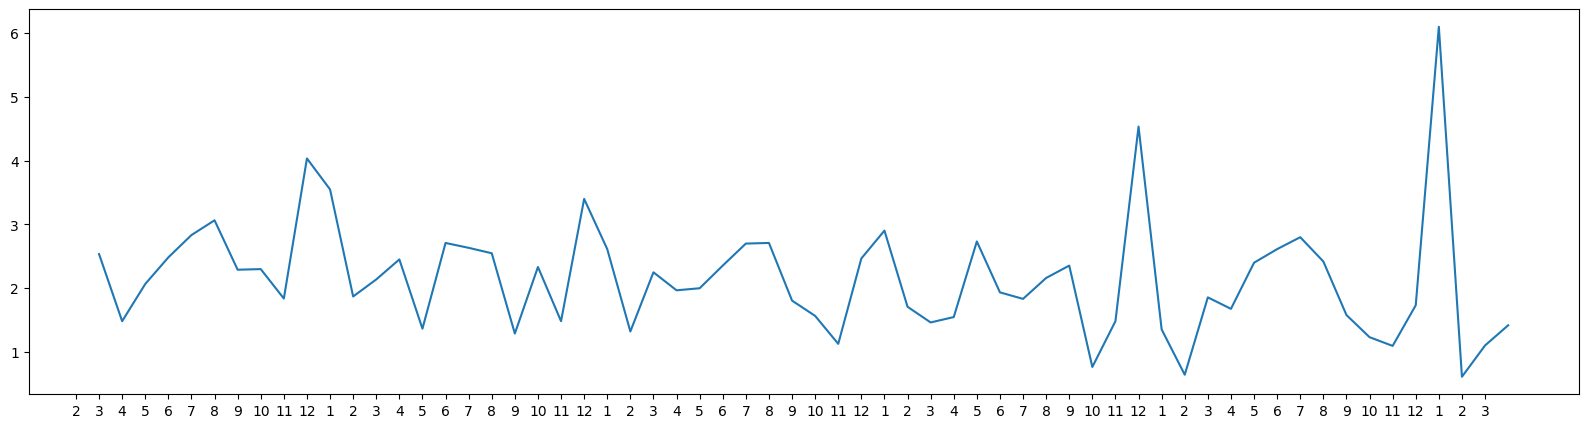

In [15]:
import matplotlib.pyplot as plt
row_name = 'FOODS_3_015_CA_1_validation'
item_data = sales.loc[sales['id'] == row_name].copy()
calendar_history = calendar.iloc[:len(d_cols)].copy()
months = calendar_history["month"].astype(int)
item_sales = item_data[d_cols].values[0]
data = np.array([item_sales, months]).T

from itertools import groupby
groups = [list(values) for key, values in groupby(np.arange(data.shape[0]), lambda i: int(months[i]))]
group_indices = np.zeros(data.shape[0])
for group_index, group in enumerate(groups):
    for i in group:
        group_indices[i] = group_index
item_dt = pd.DataFrame(data=np.array([item_sales, months]).T, columns=["sale", "month"])
mean_sale_by_month = item_dt.groupby(group_indices).mean().iloc[1:-1]
plt.plot(mean_sale_by_month["sale"])
plt.xticks(np.arange(mean_sale_by_month.shape[0]), map(lambda x: int(x), mean_sale_by_month["month"]))
plt.show()

我们发现，每年的12月和1月前后，该商品的销量都会比其他月份高一些。而3月和4月前后的销量偏低。故该商品的销量变化呈现出一定的周期性规律。这提醒我们在预测销量时，可以参考历史数据中与预测目标日期位于同一月份的日期的销量。

因此，我们挑出历史数据中所有与目标预测日期所在月份相同的日期，并计算他们的销量平均值。

In [16]:
def get_same_month_mean_feature(target_day, predict_distance):
    calendar_history = calendar.loc[calendar.index < target_day - predict_distance]
    target_date_month = int(calendar.iloc[target_day - 1]["month"]) # 目标日期所在的月份
    same_month_dates = calendar_history.loc[calendar_history["month"].astype(int) == target_date_month]["d"] # 月份与 target_date_month 相同的所有日期
    same_month_mean = x[same_month_dates].mean(axis=1) # 计算目标日期所在的月份所有销量的平均值
    return pd.DataFrame(same_month_mean, columns=["same_month_mean"])

get_same_month_mean_feature(target_day, predict_distance)

,same_month_mean
0,0.321839
1,0.114943
2,0.160920
3,1.718391
4,0.666667
...,...
30485,0.666667
30486,0.568966
30487,0.959770
30488,0.287356


此外，日历信息还包含了特殊事件。例如，当天是否在NBA总决赛期间、当天是否父亲节、所在州当天是否允许SNAP的食品消费券等等。这些特殊事件对商品的销量也会有显著影响。例如，我们发现FOODS_3_015_CA_1这一商品在NBA决赛期间平均销量略高于其他日期的平均销量。

In [17]:
calendar_history = calendar.loc[calendar.index < target_day - predict_distance]
print(item_dt.loc[calendar_history["event_name_1"] == "NBAFinalsEnd"]["sale"].mean())
print(item_dt.loc[calendar_history["event_name_1"] != "NBAFinalsEnd"]["sale"].mean())

3.4
2.1378406708595388


故如果目标预测日期发生了某一特殊事件（event_name不为NaN），则我们计算历史数据中发生相同事件的日期的销量平均值。如果目标预测日期没有特殊事件，则这些特征记为NaN。此外，我们也计算历史当中与目标预测日期使用SNAP消费券情况相同的所有日期的销量平均值。

In [18]:
all_event_name_1 = np.unique(list(filter(lambda val: isinstance(val ,str), calendar["event_name_1"].values)))
all_event_name_2 = np.unique(list(filter(lambda val: isinstance(val ,str), calendar["event_name_2"].values)))
all_event_type_1 = np.unique(list(filter(lambda val: isinstance(val ,str), calendar["event_type_1"].values)))
all_event_type_2 = np.unique(list(filter(lambda val: isinstance(val ,str), calendar["event_type_2"].values)))
all_event_list = np.hstack([all_event_name_1, all_event_name_2, all_event_type_1, all_event_type_2])


In [19]:

def get_event_features(target_day, predict_distance):
    event_mean_price_table = pd.DataFrame()

    def add_event_mean_features(event_list, event_key, target_day, predict_distance):
        calendar_history = calendar.loc[calendar.index < target_day - predict_distance]
        for event in event_list:
            if event == "nan":
                continue
            str_event_col = np.array(list(map(lambda val: str(val), calendar_history[event_key].values)))
            event_d_cols = calendar_history.loc[str_event_col == event]["d"]
            event_mean_price_table[event + "_mean_price"] = x[event_d_cols].mean(axis=1)

    add_event_mean_features(all_event_name_1, "event_name_1", target_day, predict_distance)
    add_event_mean_features(all_event_name_2, "event_name_2", target_day, predict_distance)
    add_event_mean_features(all_event_type_1, "event_type_1", target_day, predict_distance)
    add_event_mean_features(all_event_type_2, "event_type_2", target_day, predict_distance)
    
    target_day_event_name_1 = calendar.iloc[target_day - 1]["event_name_1"]
    target_day_event_name_2 = calendar.iloc[target_day - 1]["event_name_2"]
    target_day_event_type_1 = calendar.iloc[target_day - 1]["event_type_1"]
    target_day_event_type_2 = calendar.iloc[target_day - 1]["event_type_2"]

    event_feature = pd.DataFrame(data=np.zeros([sales.shape[0], 0]))
    #series_nan = pd.Series(np.ones(sales.shape[0]) * np.nan, dtype=np.float, index=np.arange(sales.shape[0]))
    series_nan = pd.Series(np.ones(sales.shape[0]) * float('nan'), dtype=float, index=np.arange(sales.shape[0]))
    event_feature["event_name_1_mean"] = series_nan if not isinstance(target_day_event_name_1, str) else\
        event_mean_price_table[target_day_event_name_1 + "_mean_price"]
    event_feature["event_name_2_mean"] = series_nan if not isinstance(target_day_event_name_2, str) else\
        event_mean_price_table[target_day_event_name_2 + "_mean_price"]
    event_feature["event_type_1_mean"] = series_nan if not isinstance(target_day_event_type_1, str) else\
        event_mean_price_table[target_day_event_type_1 + "_mean_price"]
    event_feature["event_type_2_mean"] = series_nan if not isinstance(target_day_event_type_2, str) else\
        event_mean_price_table[target_day_event_type_2 + "_mean_price"]
    return event_feature

get_event_features(target_day, predict_distance)

,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
30485,NaN,NaN,NaN,NaN
30486,NaN,NaN,NaN,NaN
30487,NaN,NaN,NaN,NaN
30488,NaN,NaN,NaN,NaN


In [20]:
get_event_features(target_day, predict_distance).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   event_name_1_mean  0 non-null      float64
 1   event_name_2_mean  0 non-null      float64
 2   event_type_1_mean  0 non-null      float64
 3   event_type_2_mean  0 non-null      float64
dtypes: float64(4)
memory usage: 952.9 KB


In [21]:
states = ["CA", "TX", "WI"]

def get_snap_feature(target_day, predict_distance):
    snap_feature = pd.DataFrame(data=np.zeros([sales.shape[0], 1]), columns=["snap_mean"])
    calendar_history = calendar.loc[calendar.index < target_day - predict_distance]
    for state in states:
        snap_col = "snap_" + state
        state_data_indices = np.array(list(map(lambda val: val.split("_")[3] == state, sales["id"].values)))
        snap_d_cols = calendar_history.loc[calendar_history[snap_col] == 1]["d"]
        no_snap_d_cols = calendar_history.loc[calendar_history[snap_col] == 0]["d"]
        state_snap_mean = sales.loc[state_data_indices][snap_d_cols].mean(axis=1)
        state_no_snap_mean = sales.loc[state_data_indices][no_snap_d_cols].mean(axis=1)
        if calendar.iloc[target_day - 1][snap_col] == 1:
            snap_feature.loc[state_data_indices, "snap_mean"] = state_snap_mean
        else:
            snap_feature.loc[state_data_indices, "snap_mean"] = state_no_snap_mean
    return snap_feature

get_snap_feature(target_day, predict_distance)

,snap_mean
0,0.316446
1,0.254871
2,0.153546
3,1.713952
4,0.996103
...,...
30485,0.489478
30486,0.289945
30487,0.694466
30488,0.328917


综上，我们从日历信息中共得到以下6个特征。

In [22]:
def get_calendar_features(target_day, predict_distance):
    return pd.concat([get_same_month_mean_feature(target_day, predict_distance),
                      get_event_features(target_day, predict_distance),
                      get_snap_feature(target_day, predict_distance)], axis=1)

get_calendar_features(target_day, predict_distance)

,same_month_mean,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean,snap_mean
0,0.321839,NaN,NaN,NaN,NaN,0.316446
1,0.114943,NaN,NaN,NaN,NaN,0.254871
2,0.160920,NaN,NaN,NaN,NaN,0.153546
3,1.718391,NaN,NaN,NaN,NaN,1.713952
4,0.666667,NaN,NaN,NaN,NaN,0.996103
...,...,...,...,...,...,...
30485,0.666667,NaN,NaN,NaN,NaN,0.489478
30486,0.568966,NaN,NaN,NaN,NaN,0.289945
30487,0.959770,NaN,NaN,NaN,NaN,0.694466
30488,0.287356,NaN,NaN,NaN,NaN,0.328917


In [23]:
get_calendar_features(target_day, predict_distance).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   same_month_mean    30490 non-null  float64
 1   event_name_1_mean  0 non-null      float64
 2   event_name_2_mean  0 non-null      float64
 3   event_type_1_mean  0 non-null      float64
 4   event_type_2_mean  0 non-null      float64
 5   snap_mean          30490 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB


#### 价格特征

最后，我们尝试利用商品的历史价格信息。商品的价格一定程度上可以反应其市场供需情况，故理论上对销量的预测也有参考价值。首先观察一下FOODS_3_015_CA_1这个商品每周的价格与其销量的关系。

d:\Development\anaconda3\envs\ml\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


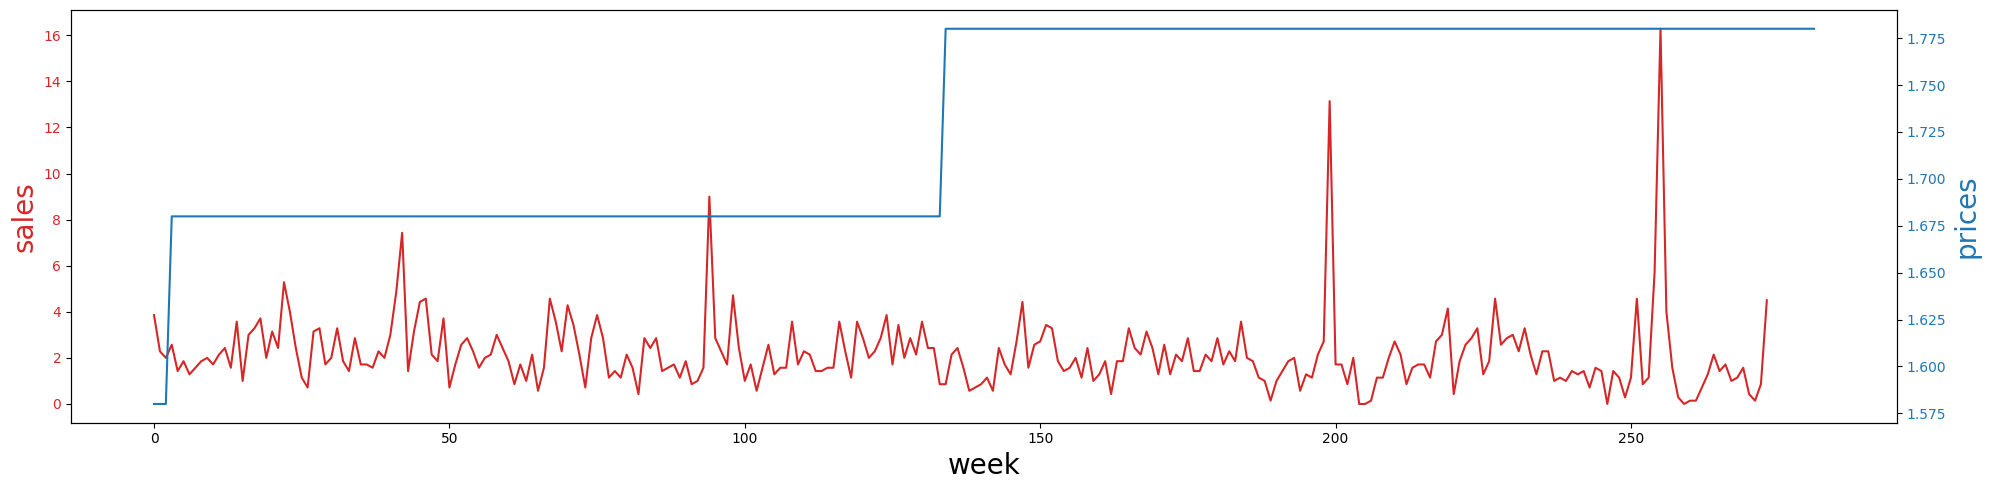

In [24]:
row_name = 'FOODS_3_015_CA_1_validation'
calendar_history = calendar.iloc[:target_day - 1].copy()
calendar_history["index_group"] = calendar_history.index
index_group_by_week = [list(value) for key, value in calendar_history.groupby("wm_yr_wk")["index_group"]]
group_indices = np.zeros(len(d_cols), dtype=np.int)
for group_index, group in enumerate(index_group_by_week):
    for row_id in group:
        group_indices[row_id] = int(group_index)
week_sale = sales.loc[sales["id"] == row_name][d_cols].groupby(group_indices, axis=1).mean().values[0]
zip_result = list(zip(sell_prices["item_id"].values, sell_prices["store_id"].values))
item_store_id = list(map(lambda x: x[0] + "_" + x[1] + "_validation", zip_result))
sell_prices["item_store_id"] = item_store_id
week_price = sell_prices.loc[sell_prices["item_store_id"] == row_name].groupby("wm_yr_wk").mean()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('week', fontsize=20)
ax1.set_ylabel('sales', color=color, fontsize=20)
ax1.plot(np.arange(len(week_sale)), week_sale, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('prices', color=color, fontsize=20)
ax2.plot(np.arange(len(week_price)), week_price, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

与预想的不同，我们发现商品的价格并没有太频繁地波动，无法观察到商品价格与销量的明显关系。其他序列也是类似的情况。因此，我们暂时不考虑将价格信息加入到特征当中。读者可以思考一下如何使用价格信息构造出合理的特征。

最后，我们将所有的特征连接到一起。

In [25]:
def get_all_features(target_day, predict_distance):
    return pd.concat([get_history_features(target_day, predict_distance),
                      get_calendar_features(target_day, predict_distance)], axis=1)

get_all_features(target_day, predict_distance)

,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,...,p_5,p_6,p_7,p_8,same_month_mean,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean,snap_mean
0,1.0,2.0,2.0,5.0,6.0,7.0,8.0,13.0,25.0,27.0,...,3.0,3.0,3.0,3.0,0.321839,NaN,NaN,NaN,NaN,0.316446
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,2.0,2.0,0.114943,NaN,NaN,NaN,NaN,0.254871
2,1.0,2.0,3.0,3.0,4.0,5.0,6.0,14.0,15.0,16.0,...,1.0,1.0,2.0,2.0,0.160920,NaN,NaN,NaN,NaN,0.153546
3,2.0,9.0,12.0,13.0,13.0,14.0,18.0,29.0,45.0,51.0,...,11.0,14.0,17.0,17.0,1.718391,NaN,NaN,NaN,NaN,1.713952
4,4.0,6.0,8.0,10.0,11.0,12.0,12.0,20.0,24.0,38.0,...,5.0,7.0,9.0,10.0,0.666667,NaN,NaN,NaN,NaN,0.996103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,1.0,1.0,1.0,2.0,2.0,2.0,2.0,6.0,6.0,6.0,...,2.0,2.0,3.0,3.0,0.666667,NaN,NaN,NaN,NaN,0.489478
30486,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,7.0,9.0,...,3.0,3.0,3.0,3.0,0.568966,NaN,NaN,NaN,NaN,0.289945
30487,0.0,1.0,1.0,1.0,2.0,2.0,4.0,11.0,22.0,25.0,...,11.0,11.0,12.0,13.0,0.959770,NaN,NaN,NaN,NaN,0.694466
30488,3.0,4.0,7.0,7.0,8.0,8.0,8.0,13.0,22.0,26.0,...,5.0,5.0,5.0,7.0,0.287356,NaN,NaN,NaN,NaN,0.328917


In [26]:
get_all_features(target_day, predict_distance).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   la_1               30490 non-null  float64
 1   la_2               30490 non-null  float64
 2   la_3               30490 non-null  float64
 3   la_4               30490 non-null  float64
 4   la_5               30490 non-null  float64
 5   la_6               30490 non-null  float64
 6   la_7               30490 non-null  float64
 7   la_14              30490 non-null  float64
 8   la_21              30490 non-null  float64
 9   la_28              30490 non-null  float64
 10  la_42              30490 non-null  float64
 11  la_56              30490 non-null  float64
 12  p_1                30490 non-null  float64
 13  p_2                30490 non-null  float64
 14  p_3                30490 non-null  float64
 15  p_4                30490 non-null  float64
 16  p_5                304

注意，以上我们只是计算了第1914天的数据的特征。这只些特征只能用来预测1914天的销量，也就是说，上表实际上是我们的测试数据。

为了构造训练数据，我们对1914天之前的日期进行同样的特征计算操作，并附上它们的当天销量作为数据标签。下面我们来详细说明。

### 构造训练数据

在时间序列的问题中，训练数据的构造一般使用滑窗的方式构造。以本案例为例，训练数据提供了长度为1913的历史序列。假设我们建模了一个单步模型，只预测下一天，那么，基于原始数据中的每一条序列，我们最多可以构造出1913条训练样本。但在这里面，时间靠前的那些样本，可以利用的历史信息就很少。因此，我们一般还要预留一个**特征窗口**，保证每条样本都可以抽取足够的信息。假设我们要保证每条样本至少有56天的历史信息，那么我们就需要从第57天开始滑窗。这一共可以构造出1857条样本。如果要需要预测的步长变大，比如预测后天的销量，那可以构造的样本也会变少一条。综上，对于一条时间序列，我们可以构造出 $H - f - l + 1$ 的样本，其中，H是序列的长度(本案例中为1913)，f是每条样本的最小历史信息（本案例中为56），l是预测的步长（即predict_distance）。

下面，我们来构造训练数据集。为了节约时间和内存，这里我们只选用第1914的前50天构造训练数据。读者可根据自己的情况选取更多的日期进行构造。

In [27]:
training_data_days = 50

In [28]:
def get_data(target_day, predict_distance):
    test_data = get_all_features(target_day, predict_distance)
    train_data = pd.DataFrame(columns=test_data.columns)
    for day in range(target_day - training_data_days - predict_distance + 1, target_day - predict_distance + 1):
        train_data = pd.concat([train_data, get_all_features(day, predict_distance)])
    return train_data, test_data

train_data, test_data = get_data(target_day, predict_distance)
train_data

,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,...,p_5,p_6,p_7,p_8,same_month_mean,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean,snap_mean
0,51.0,52.0,53.0,53.0,55.0,55.0,57.0,67.0,71.0,80.0,...,3.0,3.0,3.0,3.0,0.243750,NaN,NaN,NaN,NaN,0.289431
1,10.0,10.0,11.0,11.0,11.0,11.0,11.0,12.0,14.0,15.0,...,0.0,0.0,0.0,0.0,0.125000,NaN,NaN,NaN,NaN,0.265041
2,31.0,31.0,31.0,31.0,31.0,31.0,31.0,32.0,34.0,40.0,...,2.0,2.0,2.0,2.0,0.175000,NaN,NaN,NaN,NaN,0.138211
3,103.0,103.0,104.0,104.0,104.0,104.0,110.0,123.0,131.0,153.0,...,23.0,31.0,33.0,33.0,1.681250,NaN,NaN,NaN,NaN,1.720325
4,65.0,65.0,65.0,66.0,68.0,69.0,70.0,78.0,85.0,94.0,...,7.0,10.0,11.0,14.0,0.625000,NaN,NaN,NaN,NaN,0.907317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,1.0,1.0,2.0,2.0,2.0,2.0,2.0,6.0,6.0,6.0,...,0.0,0.0,1.0,2.0,0.664740,NaN,NaN,NaN,NaN,0.489080
30486,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,8.0,9.0,...,2.0,2.0,2.0,2.0,0.572254,NaN,NaN,NaN,NaN,0.290172
30487,1.0,1.0,1.0,2.0,2.0,4.0,4.0,13.0,23.0,26.0,...,4.0,5.0,7.0,7.0,0.965318,NaN,NaN,NaN,NaN,0.695008
30488,4.0,7.0,7.0,8.0,8.0,8.0,9.0,15.0,23.0,30.0,...,9.0,12.0,14.0,14.0,0.271676,NaN,NaN,NaN,NaN,0.326833


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524500 entries, 0 to 30489
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   la_1               1524500 non-null  float64
 1   la_2               1524500 non-null  float64
 2   la_3               1524500 non-null  float64
 3   la_4               1524500 non-null  float64
 4   la_5               1524500 non-null  float64
 5   la_6               1524500 non-null  float64
 6   la_7               1524500 non-null  float64
 7   la_14              1524500 non-null  float64
 8   la_21              1524500 non-null  float64
 9   la_28              1524500 non-null  float64
 10  la_42              1524500 non-null  float64
 11  la_56              1524500 non-null  float64
 12  p_1                1524500 non-null  float64
 13  p_2                1524500 non-null  float64
 14  p_3                1524500 non-null  float64
 15  p_4                1524500 non-nul

In [30]:
train_data['event_name_2_mean'] = pd.to_numeric(train_data['event_name_2_mean'], errors='coerce')
train_data['event_type_2_mean'] = pd.to_numeric(train_data['event_type_2_mean'], errors='coerce')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524500 entries, 0 to 30489
Data columns (total 26 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   la_1               1524500 non-null  float64
 1   la_2               1524500 non-null  float64
 2   la_3               1524500 non-null  float64
 3   la_4               1524500 non-null  float64
 4   la_5               1524500 non-null  float64
 5   la_6               1524500 non-null  float64
 6   la_7               1524500 non-null  float64
 7   la_14              1524500 non-null  float64
 8   la_21              1524500 non-null  float64
 9   la_28              1524500 non-null  float64
 10  la_42              1524500 non-null  float64
 11  la_56              1524500 non-null  float64
 12  p_1                1524500 non-null  float64
 13  p_2                1524500 non-null  float64
 14  p_3                1524500 non-null  float64
 15  p_4                1524500 non-nul

In [31]:
label_data = pd.read_csv("./data/sales_train_evaluation.csv")

def get_label(target_day, predict_distance):
    test_label = label_data["d_" + str(target_day)]
    train_label = pd.DataFrame()
    for day in range(target_day - training_data_days - predict_distance + 1, target_day - predict_distance + 1):
        train_label = pd.concat([train_label, label_data["d_" + str(day)]], axis=0)
    return train_label, test_label

train_label, test_label = get_label(target_day, predict_distance)
train_label

,0
0,1.0
1,1.0
2,1.0
3,5.0
4,0.0
...,...
30485,1.0
30486,0.0
30487,0.0
30488,3.0


以上我们仅仅针对target_day=1914和preidct_distance=1构建了数据和标签，接下来的调参和训练过程也只针对第1914天的预测来进行。如果想要预测其他日期的销量，只需要更改get_data和get_label的参数即可。例如，想要预测第1915天的销量，只要调用get_data(1915, 2), get_label(1915, 2)来获得数据，并同样根据以下的过程进行模型训练（注意，由于训练数据中只有到1913天的数据，故在预测第1915天时需要设置predict_distance=2）。

现在，我们已经准备好了训练数据和测试数据的特征和标签。接下来可以开始进行调参和训练了。

### 调参和训练

首先，导入LightGBM的python包。

In [32]:
import lightgbm as lgb

接着，创建训练数据和测试数据，代码如下。导入数据集之后，LightGBM会根据超参数，在数据集中加入一些额外的结构信息，例如，哪些特征属于类别特征、特征值离散化的边界等等。创建test_set时，我们需要设置reference=train_set，这使得test_set的结构信息与train_set保持一致。

`feature_pre_filter`默认为`True`，lightgbm会根据min_data_in_leaf的值提前把一些不可能找到合法分割的特征过滤。由于后面会调整min_data_in_leaf，我们不希望反复构造数据集，我们将设置`feature_pre_filter=False`，这样`min_data_in_leaf`的选取不会影响到Dataset的构建。

In [33]:
params = {
    "feature_pre_filter": False
}

train_set = lgb.Dataset(train_data, label=train_label, params=params)
test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)

首先使用一组默认的超参数训练一下，观察在测试集上的效果。

In [34]:
params = {
    'objective':'regression' #设置目标函数为regression，将会使用最小均方误差(MSE)作为目标函数。其他超参数保持默认。
}
model = lgb.train(params=params, train_set=train_set, valid_sets=[test_set], valid_names=["test"])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5362
[LightGBM] [Info] Number of data points in the train set: 1524500, number of used features: 26
[LightGBM] [Info] Start training from score 1.386903


d:\Development\anaconda3\envs\ml\lib\site-packages\lightgbm\basic.py:2171: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


可以观察到，测试集上的均方误差（即l2损失值），先是随着训练迭代次数的增加而下降，在第30轮之后降到最低值，随后开始上升。这说明在30轮迭代之后模型开始过拟合训练数据，到了100轮迭代之后，均方误差已经上升了不少。因此，合适的迭代次数对模型的表现非常关键，此外GBDT还有其他非常重要的超参数。以下是GBDT的重要超参数以及它们在LightGBM中对应的名称。


|超参数 | 作用 | 在LightGBM中的名称 |
| --- | --- | --- |
|迭代次数|即GBDT使用的决策树的数量。集成更多的决策树<br>可以提高模型的表示能力，但是也容易导致过拟合。 | num_trees |
|学习率|即每棵决策树在最终模型中的权重。过大的学习率<br>会导致模型拟合效果不佳。但是使用小的学习率<br>通常需要更多的决策树。|learning_rate|
|决策树规模|每棵决策树叶子的数量，使用更大的决策树可以提高拟合<br>能力，但是也容易导致过拟合。|num_leaves|

除了以上三个对模型表现有特别大影响的参数之外，LightGBM中还有一些重要的正则化参数。

|LightGBM超参数 | 作用 |
|---|---|
|min_data_in_leaf|限制每片叶子上最少允许的数据量|
|lambda_l2|叶子上预测值的l2正则权重|
|bagging_fraction|每棵树训练采样的训练样本比例|
|feature_fraction|每棵树训练采样的特征比例|

更多LightGBM的超参数及它们的作用可以参考
https://lightgbm.readthedocs.io/en/latest/Parameters.html
以及https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
。

下面将展示如何通过手动的方法对LightGBM进行调参。

#### 手动调参

调参时，将train_set中最后一天的数据作为验证集，其余作为训练集。

In [35]:
num_data_per_day = test_data.shape[0]
val_train_data = train_data.iloc[: -num_data_per_day]
val_test_data = train_data.iloc[-num_data_per_day :]
val_train_label = train_label[: -num_data_per_day]
val_test_label = test_label[-num_data_per_day :]

val_train_set = lgb.Dataset(data=val_train_data, label=val_train_label)
val_test_set = lgb.Dataset(data=val_test_data, label=val_test_label, reference=val_train_set)

In [36]:
params = {
    'objective': 'regression',
    'num_trees': 500,
    'verbose': -1
}
early_stopping_rounds = 10

为方便测试，先定义一个直接由超参数得到验证集上结果的函数。

In [37]:
def get_eval_result(params):
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=val_train_set,
                      valid_sets=[val_test_set],
                      valid_names=["val_test"],
                      #verbose_eval=False
                      callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=early_stopping_rounds),lgb.record_evaluation(evals_result)]
                      )
    return evals_result["val_test"]["l2"][model.best_iteration - 1], model.best_iteration

首先，固定学习率和最大迭代次数，调整其他超参数。为了保证能够得到测试集上最优迭代的结果，一开始固定的迭代次数会比较大，这里选取了num_trees=500。这里为了方便展示，我们仅以grid search的方式调整决策树的规模和叶子上最少允许的数据量。读者可自行加入其他超参数一起搜索。

In [38]:
num_leaves_options = [4, 8, 16, 32, 64, 128, 256]
min_data_in_leaf_options = [20, 50, 100, 200, 300, 400, 500, 1000]
for num_leaves in num_leaves_options:
    for min_data_in_leaf in min_data_in_leaf_options:
        try_params = params.copy()
        try_params.update({'num_leaves': num_leaves, 'min_data_in_leaf': min_data_in_leaf})
        l2, best_iteration = get_eval_result(try_params)
        print("best l2 loss %.6f at iteration %d with num_leaves = %d and min_data_in_leaf = %d" % 
              (l2, best_iteration, num_leaves, min_data_in_leaf))

d:\Development\anaconda3\envs\ml\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	val_test's l2: 4.02683
best l2 loss 4.026833 at iteration 30 with num_leaves = 4 and min_data_in_leaf = 20
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	val_test's l2: 4.06715
best l2 loss 4.067149 at iteration 25 with num_leaves = 4 and min_data_in_leaf = 50
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	val_test's l2: 4.05757
best l2 loss 4.057570 at iteration 28 with num_leaves = 4 and min_data_in_leaf = 100
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	val_test's l2: 4.10683
best l2 loss 4.106832 at iteration 29 with num_leaves = 4 and min_data_in_leaf = 200
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	val_test's l2: 4.09561
best l2 loss 4.095612 at iteration 29 with

我们发现，num_leaves=8并且min_data_in_leaf=20的时候结果是最好的。接下来我们调整学习率。

In [39]:
params.update({'num_leaves': 8, 'min_data_in_leaf':20})
learning_rate_options = [0.01, 0.02, 0.03, 0.05, 0.1]
for learning_rate in learning_rate_options:
    try_params = params.copy()
    try_params.update({'learning_rate': learning_rate})
    l2, best_iteration = get_eval_result(try_params)
    print("best l2 loss %.6f at iteration %d with learning_rate = %f" % (l2, best_iteration, learning_rate))

Training until validation scores don't improve for 10 rounds
[100]	val_test's l2: 4.51314
[200]	val_test's l2: 3.94233
Early stopping, best iteration is:
[224]	val_test's l2: 3.9336
best l2 loss 3.933602 at iteration 224 with learning_rate = 0.010000
Training until validation scores don't improve for 10 rounds
[100]	val_test's l2: 3.94184
Early stopping, best iteration is:
[114]	val_test's l2: 3.93176
best l2 loss 3.931762 at iteration 114 with learning_rate = 0.020000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	val_test's l2: 3.93863
best l2 loss 3.938628 at iteration 72 with learning_rate = 0.030000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	val_test's l2: 3.95931
best l2 loss 3.959307 at iteration 41 with learning_rate = 0.050000
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	val_test's l2: 3.97446
best l2 loss 3.974

可见learning_rate=0.02且迭代次数为114是最好的。我们使用搜索出的最优超参，在全部训练集上进行训练，并观察测试集的结果

In [40]:
params.update({'learning_rate':0.02, 'num_trees':114})
model = lgb.train(params=params,
                      train_set=train_set)
score = model.predict(test_data)


In [46]:
score

array([0.64026911, 0.3370302 , 0.41818999, ..., 0.61235944, 0.66949203,
       0.71714955])

In [50]:
test_label

0        0
1        0
2        0
3        0
4        1
        ..
30485    0
30486    0
30487    0
30488    1
30489    0
Name: d_1914, Length: 30490, dtype: int64

In [48]:
l2_loss = np.mean((score - test_label) ** 2)
l2_loss

4.225438548911833

得到最终测试集上l2损失函数值为4.22544，这比一开始默认参数取得的结果5.27666有了不少的提高。

### 模型解释

在训练得到GBDT模型之后，可以对模型进行解释分析，从而了解特征对模型预测所起的作用。这里主要介绍两种解释工具，分别是特征重要性以及SHAP值。此外，LightGBM还提供了模型可视化接口，用户可以方便地查看每个决策树的结构。

#### 特征重要性

特征重要性描述每个特征在GBDT模型中的整体贡献。常用的特征重要性计算方法有：
1. 计算特征在切分条件当中使用的次数。
2. 计算使用该特征所有切分的增益之和。

二者在LightGBM中都可以通过直接调用模型的feature_importance方法获得。

In [41]:
def print_feature_importance(importance_type):
    feature_importance_count = model.feature_importance(importance_type=importance_type)
    feature_names = train_data.columns
    argsort = np.argsort(feature_importance_count)
    for idx in argsort[::-1]:
        print("feature %s with %s %f" % (feature_names[idx], importance_type, feature_importance_count[idx]))

按照第1种方法，即特征使用次数（指定importance_type为split）计算特征重要性，并将特征按照重要性排序。

In [42]:
print_feature_importance("split")

feature la_42 with split 120.000000
feature p_8 with split 115.000000
feature p_1 with split 82.000000
feature p_5 with split 82.000000
feature la_28 with split 67.000000
feature la_56 with split 62.000000
feature la_21 with split 51.000000
feature la_1 with split 44.000000
feature p_4 with split 36.000000
feature p_6 with split 34.000000
feature p_2 with split 26.000000
feature snap_mean with split 26.000000
feature p_7 with split 21.000000
feature la_14 with split 15.000000
feature p_3 with split 14.000000
feature la_7 with split 2.000000
feature la_2 with split 1.000000
feature event_type_2_mean with split 0.000000
feature same_month_mean with split 0.000000
feature event_name_1_mean with split 0.000000
feature event_name_2_mean with split 0.000000
feature la_6 with split 0.000000
feature la_5 with split 0.000000
feature la_4 with split 0.000000
feature la_3 with split 0.000000
feature event_type_1_mean with split 0.000000


按照第2种方式，即特征带来的切分增益之和（指定importance_type为gain）计算特征重要性，并将特征按照重要性排序。

In [43]:
print_feature_importance("gain")

feature la_42 with gain 115750132.190430
feature la_56 with gain 84476708.498047
feature p_5 with gain 31033226.599609
feature la_28 with gain 27731372.906250
feature p_8 with gain 21166530.315430
feature p_4 with gain 15516459.207031
feature p_6 with gain 11646842.912109
feature p_1 with gain 10153382.997070
feature p_7 with gain 10071173.701172
feature la_21 with gain 6105789.902344
feature p_2 with gain 4244621.695312
feature p_3 with gain 3106698.300781
feature la_1 with gain 1113203.497070
feature snap_mean with gain 837001.503906
feature la_14 with gain 531382.998047
feature la_7 with gain 48103.900391
feature la_2 with gain 17853.400391
feature event_type_2_mean with gain 0.000000
feature same_month_mean with gain 0.000000
feature event_name_1_mean with gain 0.000000
feature event_name_2_mean with gain 0.000000
feature event_type_1_mean with gain 0.000000
feature la_6 with gain 0.000000
feature la_5 with gain 0.000000
feature la_4 with gain 0.000000
feature la_3 with gain 0.0000

从以上的排序中可以发现，排名最靠前的是以la和p开头的延迟特征。有趣的是，最重要的延迟特征是使用较长历史数据的la_56、la_42、la_28、p_8等等。而使用短期历史数据的la_3、la_5等排名比较靠后。这可能是因为长期的累计销量比起短期的累计销量更加稳定，更能够反应商品的真实需求量。相反，使用很短的历史数据进行统计得到的结果具有更大的随机性。

同时，基于特殊事件的特征完全没有被使用到。

特征重要性的分析不仅帮助我们理解哪些因素是模型预测的重要根据，更可以帮助对特征工程进行反思，启发我们构造出更多可能有用的特征，并去掉没有帮助的特征。例如，以上结果提示我们，构造更多长期的累计销量特征有可能进一步提高模型效果。因此，特征工程——调参和训练——模型解释，这一过程实际上可以构成闭环，不断地迭代优化。

#### SHAP值

另一个重要的解释工具是SHAP值。它反映了每个特征对每个样本预测值的贡献。LightGBM也提供了SHAP值计算的功能，只需要在调用预测接口predict的时候指定pred_contrib=True即可。

In [44]:
shap_values = model.predict(test_data, pred_contrib=True)
shap = pd.DataFrame(data=shap_values, columns=list(test_data.columns.values) + ["expectation"])
pd.set_option('display.max_columns', None)
shap

,la_1,la_2,la_3,la_4,la_5,la_6,la_7,la_14,la_21,la_28,la_42,la_56,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,same_month_mean,event_name_1_mean,event_name_2_mean,event_type_1_mean,event_type_2_mean,snap_mean,expectation
0,-0.096252,-0.000018,0.0,0.0,0.0,0.0,0.002893,0.004732,0.015847,-0.098856,-0.298922,-0.113676,-0.021341,-0.019988,-0.011857,-0.018427,-0.033439,-0.010466,-0.007798,-0.036077,0.0,0.0,0.0,0.0,0.0,-0.002988,1.386903
1,-0.096243,-0.000007,0.0,0.0,0.0,0.0,-0.007053,-0.043878,-0.055069,-0.122065,-0.418101,-0.137268,-0.022044,-0.021792,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
2,-0.096243,-0.000018,0.0,0.0,0.0,0.0,-0.007053,0.011236,-0.034825,-0.118481,-0.418101,-0.137268,-0.021947,-0.019660,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
3,-0.164029,-0.000018,0.0,0.0,0.0,0.0,0.004983,0.022539,0.031736,-0.023178,0.119708,-0.095475,-0.020722,0.007415,-0.003725,-0.009705,-0.030853,-0.009752,-0.007798,0.040343,0.0,0.0,0.0,0.0,0.0,0.009147,1.386903
4,-0.022764,-0.000018,0.0,0.0,0.0,0.0,0.002893,0.024456,0.003448,-0.047541,-0.215728,-0.098155,-0.020919,-0.020979,-0.011857,-0.018324,-0.036087,-0.010362,-0.007798,-0.006639,0.0,0.0,0.0,0.0,0.0,-0.003067,1.386903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,-0.096243,-0.000007,0.0,0.0,0.0,0.0,-0.007053,-0.043878,-0.055069,-0.122065,-0.418101,-0.137268,-0.022044,-0.021792,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
30486,-0.096243,-0.000007,0.0,0.0,0.0,0.0,-0.007053,-0.043878,-0.055069,-0.122065,-0.418101,-0.137268,-0.022044,-0.021792,-0.012613,-0.019326,-0.033994,-0.010522,-0.008871,-0.038772,0.0,0.0,0.0,0.0,0.0,-0.002255,1.386903
30487,-0.145952,-0.000018,0.0,0.0,0.0,0.0,-0.007053,-0.009387,0.006524,-0.107395,-0.352248,-0.115530,-0.021686,0.008284,-0.004053,-0.010221,-0.032319,-0.010466,-0.008421,0.037261,0.0,0.0,0.0,0.0,0.0,-0.001863,1.386903
30488,-0.031551,-0.000018,0.0,0.0,0.0,0.0,0.002893,0.004732,-0.005771,-0.098450,-0.298922,-0.113676,-0.020953,-0.021859,-0.011857,-0.018840,-0.037012,-0.010466,-0.007798,-0.044795,0.0,0.0,0.0,0.0,0.0,-0.003067,1.386903


其中最后一列expectation是训练数据标签的均值。上表中每一行的数值之和等于模型对改行数据的预测值。可以发现la_28、la_42、la_56这几列SHAP值的绝对值比较大，这与特征重要性中的观察一致。
SHAP值的具体定义比较复杂，这里进行介绍，有兴趣的读者可以参考推荐阅读材料中的决策树模型SHAP值的计算方法的相关论文。

#### 模型可视化

使用LightGBM的plot_tree函数可以方便地画出模型中指定决策树的完整结构，包括中间节点上的决策条件和叶子节点的预测值。例如，下面我们画出第一棵树的结构。

ImportError: You must install graphviz and restart your session to plot tree.

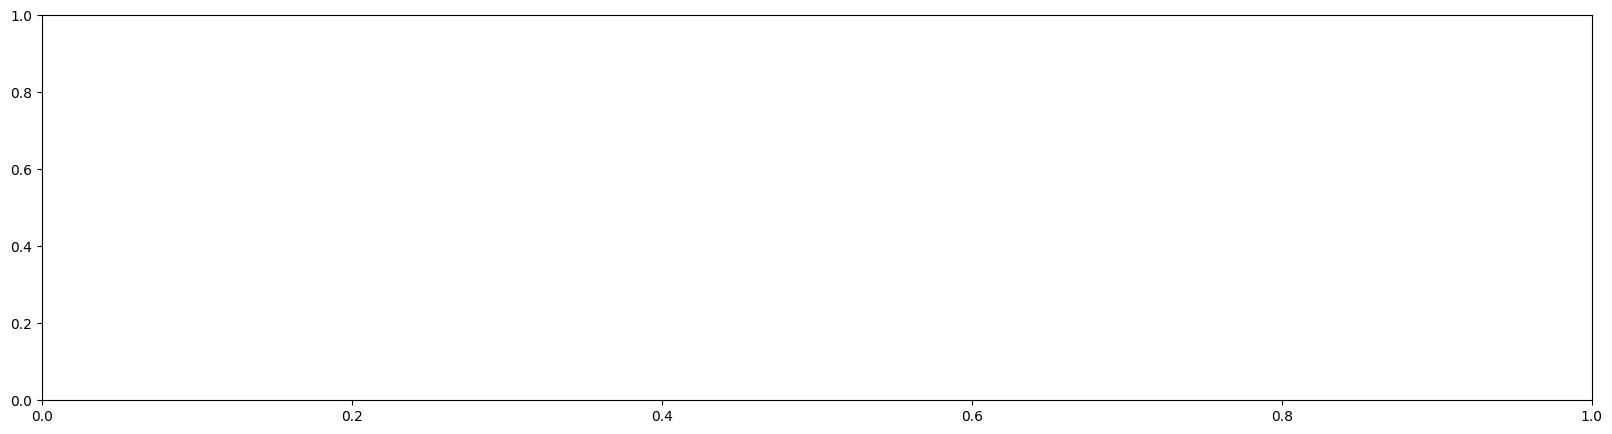

In [45]:
lgb.plot_tree(model, tree_index=0)

可以清晰地看到决策树的决策过程。在上图中，从中间节点的判断条件可知，下方的叶子节点包含的商品历史销量更大；而上方的叶子节点中的商品历史销量更小。可以看到，对于历史销量大的商品，决策树倾向于给出更大的销量预测值（如最下方的叶子的3.907）。

### LightGBM的特性使用

以上是LightGBM使用的基本流程。上述过程默认使用了LightGBM的一些特性，包括按叶子分割的决策树训练和直方图加速优化。这一小节将回过头来考察这些特性对模型的训练究竟造成了什么样的影响。

#### 决策树的生长方式

首先是按叶子分割的决策树训练。回顾在超参调优的过程中，在决策树的规模限制上，只用到了叶子的数量$num\_leaves$。这是因为LightGBM默认决策树都是按叶子分割进行训练的。当然，LightGBM也提供了对决策树最大深度的限制，由超参数$max\_depth$控制。如果设置$num\_leaves$的值为$2^{max\_depth}$，则决策树等价于按层分割的训练，得到的是一个深度为$max\_depth$的完全二叉树。在本案例中，训练样本量较多，因此使用较为灵活的按叶子分割应该得到更好的结果。我们对这一猜测进行验证。

选取使用nni自动搜参得到的最优超参数，在这组超参数中，$num\_leaves$取值为8，因此加上$max\_depth=3$，就可以让决策树都变成深度为3的完全二叉树。

In [ ]:
params_with_max_depth = {
    "num_leaves":8,
    "learning_rate":0.044462958967770576,
    "min_data_in_leaf":16,
    "lambda_l2":0.06611960419049324,
    "feature_fraction":0.6830879424448291,
    "bagging_fraction":0.7527564678754335,
    "objective": "regression",
    "bagging_freq": 1,
    "max_depth": 3
}

使用相同的迭代轮数重新训练，并观察结果

In [ ]:
params_with_max_depth.update({"num_trees": 53})
model = lgb.train(params=params_with_max_depth,
                  train_set=train_set)
score = model.predict(test_data)
l2_loss = np.mean((score - test_label) ** 2)
l2_loss

/anaconda/envs/lgbm/lib/python3.9/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5362
[LightGBM] [Info] Number of data points in the train set: 1524500, number of used features: 26
[LightGBM] [Info] Start training from score 1.386903


4.143701924725372

得到验证集上的结果为4.196662，比使用按叶子分割的4.186709差了一些。这说明按叶子分割的训练方式确实学习到了比按层分割更加灵活的决策树结构。当然，由于更换了决策树的生长方式，其他超参数可能也需要进行调整才能得到按层生长的最优结果。不过鉴于本案例中的训练数据充足，一般来说按叶子分割是更好的选择。

#### 直方图带来的加速效果

LightGBM使用直方图优化进行训练，超参数$max\_bin$指定了直方图的区间数量。前面的流程中始终将这个超参数保留为默认值$max\_bin=255$。这里我们调整$max\_bin$，依次尝试$[16, 64, 256, 512, 1024, 2048, 4096, 9192, 18384, 36768, 75536, 151072]$并观察$max\_bin$对训练速度和准确率会造成什么样的影响。

In [ ]:
params_with_max_bin = {
    "num_leaves":8,
    "learning_rate":0.044462958967770576,
    "min_data_in_leaf":16,
    "lambda_l2":0.06611960419049324,
    "feature_fraction":0.6830879424448291,
    "bagging_fraction":0.7527564678754335,
    "objective": "regression",
    "bagging_freq": 1
}
params_with_max_bin.update({"num_trees": 53})
params_with_max_bin.update({"verbose": -1})

In [ ]:
import time

for max_bin in [16, 64, 256, 512, 1024, 2048, 4096, 9192, 18384, 36768, 75536, 151072]:
    params_with_max_bin.update({"max_bin": max_bin})

    #注意，更换不同的max_bin需要重新构造LightGBM的训练数据才能生效
    train_set = lgb.Dataset(train_data, label=train_label)
    test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)

    time_start = time.time()
    model = lgb.train(params=params_with_max_bin,
                  train_set=train_set)
    time_end = time.time()
    score = model.predict(test_data)
    l2_loss = np.mean((score - test_label) ** 2)
    print("with max_bin %d, training time %s seconds, l2_loss %f" % (max_bin, (time_end - time_start), l2_loss))

with max_bin 16, training time 2.506295680999756 seconds, l2_loss 5.045216
with max_bin 64, training time 2.38858699798584 seconds, l2_loss 4.126299
with max_bin 256, training time 2.5584359169006348 seconds, l2_loss 4.183943
with max_bin 512, training time 2.5151989459991455 seconds, l2_loss 4.171627
with max_bin 1024, training time 2.5459041595458984 seconds, l2_loss 4.176913
with max_bin 2048, training time 2.560281753540039 seconds, l2_loss 4.173533
with max_bin 4096, training time 2.718515396118164 seconds, l2_loss 4.169061
with max_bin 9192, training time 2.605896472930908 seconds, l2_loss 4.172087
with max_bin 18384, training time 2.6336991786956787 seconds, l2_loss 4.165019
with max_bin 36768, training time 2.8722853660583496 seconds, l2_loss 4.164789
with max_bin 75536, training time 3.097911834716797 seconds, l2_loss 4.163614
with max_bin 151072, training time 2.7406954765319824 seconds, l2_loss 4.163613


可以看到$max\_bin$增大到一定值以后，训练时间明显变慢，并且也未必能带来准确率上的优势。在以上结果中，测试集上损失函数最低的是使用$max\_bin=64$。除了$max\_bin=16$以外，其他结果的损失函数值没有太大差别，说明准确率对$max\_bin$并不是很敏感。

#### 梯度单边采样(GOSS)

以上过程使用的采样策略为默认的随机等概率采样，即每个决策树随机等概率采样$bagging\_fraction$指定的样本比例。在背景介绍中，我们提到了LightGBM实现了一种更高效的采样方法GOSS，它基于梯度对样本进行采样，从而减少采样带来的准确率损失。GOSS的采样率由两个超参数决定，其中$top\_rate$指定了梯度最大的被保留的样本比例（对应背景介绍部分的$a$），$other\_rate$指定了剩余样本中随机等概率采样的比例（对应背景介绍部分的$b$）。为了比较GOSS和随机等概率采样的效果，将自动搜参得到的最优参数中的$bagging\_fraction$替换为两个$top\_rate$和$other\_rate$的值，并使得$top\_rate+other\_rate=bagging\_fraction$，并设置$boosting\_type$为$goss$（默认的$boosting\_type$为$gbdt$）。

In [ ]:
bagging_fraction = 0.7527564678754335
params_with_goss = {
    "top_rate": 0.3,
    "other_rate": bagging_fraction - 0.3,
    "boosting_type": "goss",
    "num_leaves":8,
    "learning_rate":0.044462958967770576,
    "min_data_in_leaf":16,
    "lambda_l2":0.06611960419049324,
    "feature_fraction":0.6830879424448291,
    "objective": "regression"
}
params_with_goss.update({"num_trees": 53})

In [ ]:
train_set = lgb.Dataset(train_data, label=train_label)
test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)
model = lgb.train(params=params_with_goss,
                  train_set=train_set)
score = model.predict(test_data)
l2_loss = np.mean((score - test_label) ** 2)
l2_loss

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5358
[LightGBM] [Info] Number of data points in the train set: 1524500, number of used features: 24
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 1.386903


4.1686802849049185

上面我们随机选取了top_rate=0.3，使用GOSS的结果略好于同采样比例的等概率随机采样(4.186709)。尝试不同的top_rate，可发现GOSS一致地好于普通的等概率随机采样。

In [ ]:
for top_rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    bagging_fraction = 0.7527564678754335
    params_with_goss = {
        "top_rate": top_rate,
        "other_rate": bagging_fraction - top_rate,
        "boosting_type": "goss",
        "num_leaves":8,
        "learning_rate":0.044462958967770576,
        "min_data_in_leaf":16,
        "lambda_l2":0.06611960419049324,
        "feature_fraction":0.6830879424448291,
        "objective": "regression"
    }
    params_with_goss.update({"num_trees": 53, "verbose":-1})
    train_set = lgb.Dataset(train_data, label=train_label)
    test_set = lgb.Dataset(test_data, label=test_label, reference=train_set)
    model = lgb.train(params=params_with_goss,
                      train_set=train_set)
    score = model.predict(test_data)
    l2_loss = np.mean((score - test_label) ** 2)
    print("l2_loss with top rate %f = %f" % (top_rate, l2_loss))

l2_loss with top rate 0.100000 = 4.162216
l2_loss with top rate 0.200000 = 4.145472
l2_loss with top rate 0.300000 = 4.168680
l2_loss with top rate 0.400000 = 4.174883
l2_loss with top rate 0.500000 = 4.197601
l2_loss with top rate 0.600000 = 4.183351
